## 

# Evaluation of LLM on Short Description Classification

In this notebook, we evaluate the performance of a large language model (LLM) on a classification task involving short textual descriptions.

We created a manually labeled test set to assess how well the LLM can handle this limited-context scenario. Since these descriptions are very short, the model may lack sufficient context to perform optimally.


## 1. Test set v3

To ensure the evaluation remains computationally feasible, we created a reduced version of the original dataset (`testset_v1_en_labeled`), resulting in `testset_v3_en_labeled`. This smaller test set includes a maximum of 50 samples per class. And we manualy double check each classification to get a very accurate testset. That's why when we plot the distribution we don't have 50 samples max per class.

In [ ]:
import json
from collections import defaultdict

def shorten_testset(input_path, output_path, max_per_sdg=50):
    sdg_counts = defaultdict(int)
    selected_entries = []

    with open(input_path, 'r', encoding='utf-8') as infile:
        for line in infile:
            try:
                entry = json.loads(line)
                sdg = entry.get("sdg", "None")
                if sdg_counts[sdg] < max_per_sdg:
                    selected_entries.append(entry)
                    sdg_counts[sdg] += 1
            except json.JSONDecodeError:
                continue  # ignore malformed lines

    with open(output_path, 'w', encoding='utf-8') as outfile:
        for entry in selected_entries:
            json.dump(entry, outfile)
            outfile.write('\n')

shorten_testset("../src/ai/testsets/testset_v1_en_labeled.jsonl", '../src/ai/testsets/testset_v3_en_labeled.jsonl')

In [17]:
import json
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import mannwhitneyu

def tesetset_distribution(testset_path):
    """
    Interactive distribution plot of SDG labels and boxplot of description_number using Plotly.

    Args:
        testset_path (str): Path to the testset file (JSONL format).
    """
    # --- Load data ---
    with open(testset_path, "r", encoding="utf-8") as f:
        data = [json.loads(line) for line in f]

    df = pd.DataFrame(data)

    # --- Plot 1: Interactive Bar Chart of SDG Labels with Counts ---
    df_sdg_counts = df["sdg"].value_counts().reset_index()
    df_sdg_counts.columns = ["sdg", "count"]

    fig_bar = px.bar(
        df_sdg_counts,
        x="sdg", y="count",
        title="Distribution of SDG Labels",
        labels={"sdg": "SDG", "count": "Count"},
        color="sdg"  # Keep color distinction
    )

    # Add count annotations on top of each bar
    for i, row in df_sdg_counts.iterrows():
        fig_bar.add_annotation(
            x=row["sdg"],
            y=row["count"],
            text=str(row["count"]),
            showarrow=False,
            yshift=10,
            font=dict(size=12, color="black")
        )

    fig_bar.update_layout(yaxis_title="Count")
    fig_bar.show()

    # --- Plot 2: Interactive Boxplot of description_number by SDG ---
    fig_box = px.box(
        df[df["sdg"] != "Error"],
        x="sdg",
        y="description_number",
        title="Description Number by SDG Category",
        points="all",
        color="sdg"
    )
    fig_box.update_layout(
        xaxis_title="SDG",
        yaxis_title="Description Number",
        boxmode="group"
    )
    fig_box.show()

    # --- Statistical test: SDG vs None (Mann-Whitney) ---
    df["has_sdg"] = df["sdg"] != "None"
    group1 = df[df["has_sdg"] == False]["description_number"]
    group2 = df[df["has_sdg"] == True]["description_number"]

    stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    print(f"\nMann-Whitney U Test p-value: {p:.4f}")
    if p < 0.05:
        print("Significant difference in description_number between 'None' and SDG-assigned.")
    else:
        print("No significant difference in description_number between 'None' and SDG-assigned.")

    # --- Plot 3: Binary boxplot: has SDG or not ---
    fig_binary = px.box(
        df,
        x="has_sdg",
        y="description_number",
        color="has_sdg",
        title="Description Number by SDG Presence",
        points="all",
        labels={"has_sdg": "Has SDG Label", "description_number": "Description Number"}
    )
    fig_binary.update_xaxes(
        tickvals=[True, False],
        ticktext=["SDG Assigned", "None"]
    )
    fig_binary.show()



tesetset_distribution("../src/ai/testsets/testset_v3_en_labeled.jsonl")


Mann-Whitney U Test p-value: 0.0000
Significant difference in description_number between 'None' and SDG-assigned.


## 2. Evaluation fuctions

### 2.1. Regex to extract SDGs from a string

In [7]:
import re

def extract_all_sdgs(text):
    """
    Extracts all SDGs found in a text and returns them as a standardized list.
    
    This function detects multiple SDG references in various formats including:
    - SDG followed by number (e.g., "SDG1", "SDG 2")
    - Numbers with sub-targets (e.g., "16.1", "3.4")
    - Standalone numbers at the beginning or after delimiters
    - Case-insensitive matching
    
    Args:
        text (str): The input text to analyze
        
    Returns:
        list: A list of unique SDGs found in the format ["SDG1", "SDG2", ...], 
            sorted numerically, or empty list if none found
    """
    if not text or not isinstance(text, str):
        return ["None"]
    
    sdg_numbers = set()  # Use set to avoid duplicates
    
    # Pattern 1: SDG followed by number with optional sub-target
    # Captures: SDG1, sdg 2, SDG13.4, etc.
    sdg_pattern = r'(?i)\bsdg\s*(\d{1,2})(?:\.\d+)?\b'
    sdg_matches = re.findall(sdg_pattern, text)
    for match in sdg_matches:
        number = int(match)
        if 1 <= number <= 17:
            sdg_numbers.add(number)
    
    # Pattern 2: Number with sub-target (e.g., "16.1", "3.4")
    # Look for patterns like X.Y where X is 1-17
    number_with_sub_pattern = r'\b(\d{1,2})\.\d+\b'
    sub_matches = re.findall(number_with_sub_pattern, text)
    for match in sub_matches:
        number = int(match)
        if 1 <= number <= 17:
            sdg_numbers.add(number)
    
    # Pattern 3: Standalone numbers at beginning or after delimiters
    # More careful matching to avoid false positives
    # Look for numbers that are:
    # - At the start of the string followed by delimiter or end
    # - After comma/semicolon/colon followed by delimiter or end
    # - After whitespace followed by delimiter or end
    standalone_pattern = r'(?:^|[,;:]\s*|(?<=\s))(\d{1,2})(?=\s*[,;]|\s*$|\s+)'
    standalone_matches = re.findall(standalone_pattern, text.strip())
    for match in standalone_matches:
        number = int(match)
        if 1 <= number <= 17:
            sdg_numbers.add(number)
    
    # Convert to sorted list of formatted strings
    result = [f"SDG{num}" for num in sorted(sdg_numbers)]

    return ["None"] if not result else result


# Test cases to verify functionality
def test_extract_all_sdgs():
    """Test function with various input scenarios"""
    test_cases = [
        # Single SDG cases
        ("SDG1", ["SDG1"]),
        ("sdg1", ["SDG1"]),
        ("SDG 1", ["SDG1"]),
        ("sdg 1", ["SDG1"]),
        ("The target is SDG2.", ["SDG2"]),
        ("Working towards sdg 10 is important.", ["SDG10"]),
        ("... aligned with SDG 17 goals.", ["SDG17"]),
        ("Random text SDG 9 more text", ["SDG9"]),
        ("1", ["SDG1"]),
        ("16.1", ["SDG16"]),
        ("SDG13.4", ["SDG13"]),
        
        # Multiple SDG cases
        ("Something about SDG15 and SDG3.", ["SDG3", "SDG15"]),
        ("3, 4", ["SDG3", "SDG4"]),
        ("SDG1, SDG2, and SDG17", ["SDG1", "SDG2", "SDG17"]),
        ("Working on 1.1, 2.3, and SDG16", ["SDG1", "SDG2", "SDG16"]),
        ("Our project addresses SDG 3, 7.2, and sdg15.", ["SDG3", "SDG7", "SDG15"]),
        ("Goals: 1, 5, 10, 17", ["SDG1", "SDG5", "SDG10", "SDG17"]),
        
        # Edge cases
        ("efzfezf", ["None"]),
        ("", ["None"]),
        ("SDG18", ["None"]),  # Invalid SDG number
        ("SDG0", ["None"]),   # Invalid SDG number
        ("123", ["None"]),    # Number too large
        ("text with no sdgs", ["None"]),
        ("SDG1 and SDG1", ["SDG1"]),  # Duplicates should be removed
    ]
    
    print("Test Results:")
    print("-" * 60)
    all_passed = True
    
    for i, (test_input, expected) in enumerate(test_cases, 1):
        result = extract_all_sdgs(test_input)
        passed = result == expected
        all_passed &= passed
        status = "✓ PASS" if passed else "✗ FAIL"
        
        print(f"{i:2d}. {status} | '{test_input}' -> {result}")
        if not passed:
            print(f"     Expected: {expected}")
    
    print("-" * 60)
    print(f"Overall: {'All tests passed!' if all_passed else 'Some tests failed!'}")
    return all_passed


test_extract_all_sdgs()

Test Results:
------------------------------------------------------------
 1. ✓ PASS | 'SDG1' -> ['SDG1']
 2. ✓ PASS | 'sdg1' -> ['SDG1']
 3. ✓ PASS | 'SDG 1' -> ['SDG1']
 4. ✓ PASS | 'sdg 1' -> ['SDG1']
 5. ✓ PASS | 'The target is SDG2.' -> ['SDG2']
 6. ✓ PASS | 'Working towards sdg 10 is important.' -> ['SDG10']
 7. ✓ PASS | '... aligned with SDG 17 goals.' -> ['SDG17']
 8. ✓ PASS | 'Random text SDG 9 more text' -> ['SDG9']
 9. ✓ PASS | '1' -> ['SDG1']
10. ✓ PASS | '16.1' -> ['SDG16']
11. ✓ PASS | 'SDG13.4' -> ['SDG13']
12. ✓ PASS | 'Something about SDG15 and SDG3.' -> ['SDG3', 'SDG15']
13. ✓ PASS | '3, 4' -> ['SDG3', 'SDG4']
14. ✓ PASS | 'SDG1, SDG2, and SDG17' -> ['SDG1', 'SDG2', 'SDG17']
15. ✓ PASS | 'Working on 1.1, 2.3, and SDG16' -> ['SDG1', 'SDG2', 'SDG16']
16. ✓ PASS | 'Our project addresses SDG 3, 7.2, and sdg15.' -> ['SDG3', 'SDG7', 'SDG15']
17. ✓ PASS | 'Goals: 1, 5, 10, 17' -> ['SDG1', 'SDG5', 'SDG10', 'SDG17']
18. ✓ PASS | 'efzfezf' -> ['None']
19. ✓ PASS | '' -> ['None

True

### 2.2. Générate evaluation file

In [3]:
import os
import json
import time
from tqdm import tqdm
from datetime import datetime
from ai.models.classify_patent import Classify_patent
from api.config.ai_config import ai_client

def run_evaluation(model: Classify_patent, testset_path: str, output_path: str):
    """
    Runs evaluation on a JSONL test dataset, classifying each description and saving results.

    If the specified output path already exists, appends a numeric suffix (_1, _2, ...) 
    to avoid overwriting the existing file.

    For each line in the test set:
        - Extracts the 'description_text' field
        - Measures the prediction time
        - Classifies the description using `classify_description`
        - Saves the enriched line with classification results and prediction time

    At the end, appends a metadata entry containing:
        - model_name
        - testset_path
        - prompt_template_path (if available)
        - creation date

    Args:
        testset_path (str): Path to the input .jsonl test dataset.
        output_path (str): Desired path to save the output .jsonl file.

    Returns:
        None
    """

    def get_safe_output_path(path):
        """Generates a non-conflicting file path by appending a numeric suffix if needed."""
        base, ext = os.path.splitext(path)
        counter = 1
        while os.path.exists(path):
            path = f"{base}_{counter}{ext}"
            counter += 1
        return path

    # Ensure the output file won't overwrite an existing file
    safe_output_path = get_safe_output_path(output_path)

    # Read all lines for progress tracking
    with open(testset_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    with open(safe_output_path, "w", encoding="utf-8") as out_f:
        for line in tqdm(lines, desc="Running evaluation"):
            data = json.loads(line)
            description_text = data.get("description_text", "")

            # Rename sdg in true_sdg
            if "sdg" in data:
                data["true_sdg"] = data.pop("sdg")

            # Time the classification
            start_time = time.time()
            sdg_balise, reason_balise = model.generate_response(description_text)
            prediction_time = time.time() - start_time

            # Add classification results and timing to the entry
            data.update({
                "sdg_balise": sdg_balise,
                "reason_balise": reason_balise,
                "prediction_time": prediction_time
            })

            # Write enriched data to output
            out_f.write(json.dumps(data) + "\n")

        # Append metadata at the end
        meta_data = {
            "meta_data": {
                "model_name": model.model_name,
                "testset_path": testset_path,
                "prompt_name": getattr(model, "prompt_name", "N/A"),
                "date_creation": datetime.now().isoformat()
            }
        }
        out_f.write(json.dumps(meta_data) + "\n")

2025-05-26 11:47:27,613 - httpx - INFO - _send_single_request - HTTP Request: GET http://localhost:11434/api/tags "HTTP/1.1 200 OK"


### 2.3. Plot evaluation 

In [4]:
from collections import defaultdict

def show_evaluation_mono(evaluation_path: str):
    """
    Evaluates the predictions in a previously generated evaluation .jsonl file.

    Each prediction line must contain:
        - "sdg": the ground truth SDG label (e.g., "SDG3")
        - "sdg_balise": predicted SDG(s) as a string (e.g., "SDG1, SDG3, SDG7")

    A prediction is considered correct if the ground truth SDG is among the predicted SDGs.

    Statistics reported:
        - Total predictions and correct ones
        - Overall accuracy
        - Average and total prediction time
        - SDG-specific accuracy breakdown
        - Sample of incorrect predictions

    Args:
        evaluation_path (str): Path to the JSONL evaluation file created by `run_evaluation`.

    Returns:
        None
    """

    results = []
    meta_data = {}
    total_predictions = 0
    correct_predictions = 0
    total_time = 0.0
    sdg_breakdown = defaultdict(lambda: {"correct": 0, "total": 0})

    # Read and evaluate each line
    with open(evaluation_path, "r", encoding="utf-8") as f:
        for line in f:
            data = json.loads(line)
            
            if "meta_data" in data:
                meta_data = data["meta_data"]
                continue  # Skip metadata line
            
            # To avoid empty line
            if "patent_number" in data:
                true_sdg = data.get("true_sdg", "").strip()
                predicted_sdg_raw = data.get("sdg_balise", "")
                predicted_sdg_list = extract_all_sdgs(predicted_sdg_raw)

                is_correct = true_sdg in predicted_sdg_list
                total_predictions += 1
                if is_correct:
                    correct_predictions += 1

                prediction_time = data.get("prediction_time", 0.0)
                total_time += prediction_time

                sdg_breakdown[true_sdg]["total"] += 1
                if is_correct:
                    sdg_breakdown[true_sdg]["correct"] += 1

                results.append({
                    "patent_number": data.get("patent_number", "N/A"),
                    "description_text": data.get("description_text", ""),
                    "true_sdg": true_sdg,
                    "predicted_sdg": predicted_sdg_list,
                    "is_correct": is_correct
                })

    # Compute summary statistics
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0
    avg_prediction_time = total_time / total_predictions if total_predictions > 0 else 0.0
    predictions_per_second = total_predictions / total_time if total_time > 0 else 0.0
    incorrect_predictions_count = total_predictions - correct_predictions

    # Print metadata
    print(f"\n=== META DATA ===")
    for key, value in meta_data.items():
        print(f"{key}: {value}")

    # Print summary
    print(f"\n=== EVALUATION RESULTS ===")
    print(f"Total predictions: {total_predictions}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Total time: {total_time:.2f} seconds")
    print(f"Average prediction time: {avg_prediction_time:.4f} seconds")
    print(f"Predictions per second: {predictions_per_second:.2f}")
    print(f"Incorrect predictions: {incorrect_predictions_count}")
    print(f"Results loaded from: {evaluation_path}")

    # Show SDG breakdown
    print(f"\n=== SDG BREAKDOWN ===")
    for sdg, stats in sorted(sdg_breakdown.items()):
        sdg_accuracy = stats["correct"] / stats["total"] if stats["total"] > 0 else 0.0
        print(f"{sdg}: {stats['correct']}/{stats['total']} ({sdg_accuracy:.2%})")

    # Show some examples of incorrect predictions
    incorrect_results = [r for r in results if not r["is_correct"]]
    if incorrect_results:
        print(f"\n=== SAMPLE INCORRECT PREDICTIONS ===")
        for i, result in enumerate(incorrect_results[:5]):
            print(f"\nExample {i+1}:")
            print(f"Patent: {result['patent_number']}")
            print(f"Description: {result['description_text'][:100]}...")
            print(f"True SDG: {result['true_sdg']}")
            print(f"Predicted SDG: {result['predicted_sdg']}")

## 3. Reproducibility

We first examine whether running the same experiment twice times yields consistent results.

### 3.1. Generate evaluation files

In [ ]:
# Initialize model
model = Classify_patent(client=ai_client, model_name="qwen3:4b", prompt_name="sdg_label_prompt")

In [ ]:
# Generate evaluations file 1
run_evaluation(model=model, testset_path="../src/ai/testsets/testset_v3_en_labeled.jsonl", 
               output_path="../src/ai/evaluations/llm_reproductibility_4b.jsonl")

Running evaluation:   0%|          | 0/328 [00:00<?, ?it/s]

In [ ]:
# Generate evaluations file 2
run_evaluation(model=model, testset_path="../src/ai/testsets/testset_v3_en_labeled.jsonl", 
               output_path="../src/ai/evaluations/llm_reproductibility_4b_1.jsonl")

### 3.2. Plot evaluation

In [8]:
show_evaluation_mono("../src/ai/evaluations/llm_reproductibility_4b.jsonl")


=== META DATA ===
model_name: qwen3:4b
testset_path: ../src/ai/testsets/testset_v3_en_labeled.jsonl
prompt_template_path: sdg_label_prompt.md
date_creation: 2025-05-24T21:49:09.555008

=== EVALUATION RESULTS ===
Total predictions: 328
Correct predictions: 150
Accuracy: 0.4573 (45.73%)
Total time: 5450.24 seconds
Average prediction time: 16.6166 seconds
Predictions per second: 0.06
Incorrect predictions: 178
Results loaded from: ../src/ai/evaluations/llm_reproductibility_4b.jsonl

=== SDG BREAKDOWN ===
None: 5/50 (10.00%)
SDG10: 0/12 (0.00%)
SDG11: 3/18 (16.67%)
SDG12: 11/50 (22.00%)
SDG13: 13/18 (72.22%)
SDG14: 5/5 (100.00%)
SDG15: 2/4 (50.00%)
SDG16: 2/2 (100.00%)
SDG2: 0/3 (0.00%)
SDG3: 47/50 (94.00%)
SDG4: 1/7 (14.29%)
SDG6: 21/27 (77.78%)
SDG7: 9/32 (28.12%)
SDG9: 31/50 (62.00%)

=== SAMPLE INCORRECT PREDICTIONS ===

Example 1:
Patent: EP3827727A1
Description: In the first embodiment, the first mop 1a and the second mop 1 b are substantially triangular-like....
True SDG: None
Pred

In [24]:
show_evaluation_mono("../src/ai/evaluations/llm_reproductibility_4b_1.jsonl")


=== META DATA ===
model_name: qwen3:4b
testset_path: ../src/ai/testsets/testset_v3_en_labeled.jsonl
prompt_template_path: sdg_label_prompt.md
date_creation: 2025-05-24T22:54:58.027378

=== EVALUATION RESULTS ===
Total predictions: 328
Correct predictions: 156
Accuracy: 0.4756 (47.56%)
Total time: 3948.20 seconds
Average prediction time: 12.0372 seconds
Predictions per second: 0.08
Incorrect predictions: 172
Results loaded from: ../src/ai/evaluations/llm_reproductibility_4b_1.jsonl

=== SDG BREAKDOWN ===
None: 9/50 (18.00%)
SDG10: 0/12 (0.00%)
SDG11: 4/18 (22.22%)
SDG12: 11/50 (22.00%)
SDG13: 13/18 (72.22%)
SDG14: 5/5 (100.00%)
SDG15: 2/4 (50.00%)
SDG16: 2/2 (100.00%)
SDG2: 0/3 (0.00%)
SDG3: 48/50 (96.00%)
SDG4: 2/7 (28.57%)
SDG6: 20/27 (74.07%)
SDG7: 10/32 (31.25%)
SDG9: 30/50 (60.00%)

=== SAMPLE INCORRECT PREDICTIONS ===

Example 1:
Patent: EP4287161A1
Description: According to the driving assistance system 100 of the embodiment described above, the following effe...
True SDG: SDG11

## 4. Model Size

We tested various model sizes and selected the Qwen3 model for evaluation. Specifically, we assessed the performance of three variants: 1.7B, 4B, 8B and 14B parameters.


### 4.1. Generate evaluation files

In [ ]:
model = Classify_patent(client=ai_client, model_name="qwen3:1.7b", prompt_name="sdg_label_prompt")
run_evaluation(model=model, testset_path="../src/ai/testsets/testset_v3_en_labeled.jsonl", 
               output_path="../src/ai/evaluations/llm_model_size_qwen3_1-7b.jsonl")

In [ ]:
model = Classify_patent(client=ai_client, model_name="qwen3:4b", prompt_name="sdg_label_prompt")
run_evaluation(model=model, testset_path="../src/ai/testsets/testset_v3_en_labeled.jsonl", 
               output_path="../src/ai/evaluations/llm_model_size_qwen3_4b.jsonl")

In [ ]:
model = Classify_patent(client=ai_client, model_name="qwen3:8b", prompt_name="sdg_label_prompt")
run_evaluation(model=model, testset_path="../src/ai/testsets/testset_v3_en_labeled.jsonl", 
               output_path="../src/ai/evaluations/llm_model_size_qwen3_8b.jsonl")

In [ ]:
model = Classify_patent(client=ai_client, model_name="qwen3:14b", prompt_name="sdg_label_prompt")
run_evaluation(model=model, testset_path="../src/ai/testsets/testset_v3_en_labeled.jsonl", 
               output_path="../src/ai/evaluations/llm_model_size_qwen3_14b.jsonl")

### 4.2. Plot evaluation

In [ ]:
# The model 1.7b has some empty <sdg> balises wich is a problem.
show_evaluation_mono("../src/ai/evaluations/llm_model_size_qwen3_1-7b.jsonl")


=== META DATA ===

=== EVALUATION RESULTS ===
Total predictions: 328
Correct predictions: 140
Accuracy: 0.4268 (42.68%)
Total time: 3089.17 seconds
Average prediction time: 9.4182 seconds
Predictions per second: 0.11
Incorrect predictions: 188
Results loaded from: ../src/ai/evaluations/llm_model_size_qwen3_1-7b.jsonl

=== SDG BREAKDOWN ===
None: 14/50 (28.00%)
SDG10: 0/12 (0.00%)
SDG11: 6/18 (33.33%)
SDG12: 19/50 (38.00%)
SDG13: 13/18 (72.22%)
SDG14: 3/5 (60.00%)
SDG15: 1/4 (25.00%)
SDG16: 1/2 (50.00%)
SDG2: 0/3 (0.00%)
SDG3: 46/50 (92.00%)
SDG4: 2/7 (28.57%)
SDG6: 19/27 (70.37%)
SDG7: 4/32 (12.50%)
SDG9: 12/50 (24.00%)

=== SAMPLE INCORRECT PREDICTIONS ===

Example 1:
Patent: EP4516757A2
Description: A supplementary cementitious material (SCM) is a material used in conjunction with or as a partial r...
True SDG: SDG9
Predicted SDG: ['SDG11']

Example 2:
Patent: EP4054160A1
Description: Further, the switch 128L may be a pressure sensitive or membrane switch defined as a fingertip-size

In [ ]:
show_evaluation_mono("../src/ai/evaluations/llm_model_size_qwen3_4b.jsonl")


=== META DATA ===

=== EVALUATION RESULTS ===
Total predictions: 328
Correct predictions: 149
Accuracy: 0.4543 (45.43%)
Total time: 3888.93 seconds
Average prediction time: 11.8565 seconds
Predictions per second: 0.08
Incorrect predictions: 179
Results loaded from: ../src/ai/evaluations/llm_model_size_qwen3_4b.jsonl

=== SDG BREAKDOWN ===
None: 5/50 (10.00%)
SDG10: 0/12 (0.00%)
SDG11: 5/18 (27.78%)
SDG12: 8/50 (16.00%)
SDG13: 12/18 (66.67%)
SDG14: 4/5 (80.00%)
SDG15: 1/4 (25.00%)
SDG16: 2/2 (100.00%)
SDG2: 0/3 (0.00%)
SDG3: 47/50 (94.00%)
SDG4: 1/7 (14.29%)
SDG6: 21/27 (77.78%)
SDG7: 11/32 (34.38%)
SDG9: 32/50 (64.00%)

=== SAMPLE INCORRECT PREDICTIONS ===

Example 1:
Patent: EP4516757A2
Description: A supplementary cementitious material (SCM) is a material used in conjunction with or as a partial r...
True SDG: SDG9
Predicted SDG: ['SDG12', 'SDG13']

Example 2:
Patent: EP3827727A1
Description: In the first embodiment, the first mop 1a and the second mop 1 b are substantially triangul

In [ ]:
show_evaluation_mono("../src/ai/evaluations/llm_model_size_qwen3_8b.jsonl")


=== META DATA ===

=== EVALUATION RESULTS ===
Total predictions: 328
Correct predictions: 162
Accuracy: 0.4939 (49.39%)
Total time: 6087.96 seconds
Average prediction time: 18.5609 seconds
Predictions per second: 0.05
Incorrect predictions: 166
Results loaded from: ../src/ai/evaluations/llm_model_size_qwen3_8b.jsonl

=== SDG BREAKDOWN ===
None: 24/50 (48.00%)
SDG10: 0/12 (0.00%)
SDG11: 4/18 (22.22%)
SDG12: 6/50 (12.00%)
SDG13: 10/18 (55.56%)
SDG14: 4/5 (80.00%)
SDG15: 1/4 (25.00%)
SDG16: 2/2 (100.00%)
SDG2: 0/3 (0.00%)
SDG3: 42/50 (84.00%)
SDG4: 2/7 (28.57%)
SDG6: 22/27 (81.48%)
SDG7: 16/32 (50.00%)
SDG9: 29/50 (58.00%)

=== SAMPLE INCORRECT PREDICTIONS ===

Example 1:
Patent: EP4516757A2
Description: A supplementary cementitious material (SCM) is a material used in conjunction with or as a partial r...
True SDG: SDG9
Predicted SDG: ['SDG13']

Example 2:
Patent: EP4287161A1
Description: According to the driving assistance system 100 of the embodiment described above, the following eff

In [ ]:
show_evaluation_mono("../src/ai/evaluations/llm_model_size_qwen3_14b.jsonl")


=== META DATA ===
model_name: qwen3:14b
testset_path: ../src/ai/testsets/testset_v3_en_labeled.jsonl
prompt_template_path: sdg_label_prompt.md
date_creation: 2025-05-25T17:18:30.614956

=== EVALUATION RESULTS ===
Total predictions: 328
Correct predictions: 150
Accuracy: 0.4573 (45.73%)
Total time: 9016.78 seconds
Average prediction time: 27.4902 seconds
Predictions per second: 0.04
Incorrect predictions: 178
Results loaded from: ../src/ai/evaluations/llm_model_size_qwen3_14b.jsonl

=== SDG BREAKDOWN ===
None: 37/50 (74.00%)
SDG10: 0/12 (0.00%)
SDG11: 5/18 (27.78%)
SDG12: 5/50 (10.00%)
SDG13: 12/18 (66.67%)
SDG14: 4/5 (80.00%)
SDG15: 1/4 (25.00%)
SDG16: 1/2 (50.00%)
SDG2: 0/3 (0.00%)
SDG3: 41/50 (82.00%)
SDG4: 1/7 (14.29%)
SDG6: 12/27 (44.44%)
SDG7: 5/32 (15.62%)
SDG9: 26/50 (52.00%)

=== SAMPLE INCORRECT PREDICTIONS ===

Example 1:
Patent: EP4516757A2
Description: A supplementary cementitious material (SCM) is a material used in conjunction with or as a partial r...
True SDG: SDG9
Pre

## 5. Shorter model Prompt

### 5.1. Generate evaluation files

In [ ]:
model = Classify_patent(client=ai_client, model_name="qwen3:4b", prompt_name="sdg_label_prompt_short")
run_evaluation(model=model, testset_path="../src/ai/testsets/testset_v3_en_labeled.jsonl", 
               output_path="../src/ai/evaluations/llm_prompt_short_4b.jsonl")

In [5]:
model = Classify_patent(client=ai_client, model_name="qwen3:14b", prompt_name="sdg_label_prompt_short")
run_evaluation(model=model, testset_path="../src/ai/testsets/testset_v3_en_labeled.jsonl", 
               output_path="../src/ai/evaluations/llm_prompt_short_14b.jsonl")

Running evaluation: 100%|██████████| 328/328 [2:17:20<00:00, 25.12s/it]


### 5.2. Plot evaluation

In [11]:
show_evaluation_mono("../src/ai/evaluations/llm_prompt_short_4b.jsonl")


=== META DATA ===
model_name: qwen3:4b
testset_path: ../src/ai/testsets/testset_v3_en_labeled.jsonl
prompt_template_path: sdg_label_prompt_short.md
date_creation: 2025-05-24T23:57:21.573880

=== EVALUATION RESULTS ===
Total predictions: 328
Correct predictions: 148
Accuracy: 0.4512 (45.12%)
Total time: 3743.36 seconds
Average prediction time: 11.4127 seconds
Predictions per second: 0.09
Incorrect predictions: 180
Results loaded from: ../src/ai/evaluations/llm_prompt_short_4b.jsonl

=== SDG BREAKDOWN ===
None: 26/50 (52.00%)
SDG10: 0/12 (0.00%)
SDG11: 3/18 (16.67%)
SDG12: 9/50 (18.00%)
SDG13: 14/18 (77.78%)
SDG14: 4/5 (80.00%)
SDG15: 1/4 (25.00%)
SDG16: 0/2 (0.00%)
SDG2: 1/3 (33.33%)
SDG3: 33/50 (66.00%)
SDG4: 2/7 (28.57%)
SDG6: 15/27 (55.56%)
SDG7: 11/32 (34.38%)
SDG9: 29/50 (58.00%)

=== SAMPLE INCORRECT PREDICTIONS ===

Example 1:
Patent: EP4054160A1
Description: Further, the switch 128L may be a pressure sensitive or membrane switch defined as a fingertip-sized...
True SDG: SDG16
P

In [12]:
show_evaluation_mono("../src/ai/evaluations/llm_prompt_short_14b.jsonl")


=== META DATA ===
model_name: qwen3:14b
testset_path: ../src/ai/testsets/testset_v3_en_labeled.jsonl
prompt_template_path: sdg_label_prompt_short.md
date_creation: 2025-05-25T06:50:25.656681

=== EVALUATION RESULTS ===
Total predictions: 328
Correct predictions: 168
Accuracy: 0.5122 (51.22%)
Total time: 7865.16 seconds
Average prediction time: 23.9791 seconds
Predictions per second: 0.04
Incorrect predictions: 160
Results loaded from: ../src/ai/evaluations/llm_prompt_short_14b.jsonl

=== SDG BREAKDOWN ===
None: 33/50 (66.00%)
SDG10: 0/12 (0.00%)
SDG11: 2/18 (11.11%)
SDG12: 8/50 (16.00%)
SDG13: 14/18 (77.78%)
SDG14: 3/5 (60.00%)
SDG15: 2/4 (50.00%)
SDG16: 1/2 (50.00%)
SDG2: 0/3 (0.00%)
SDG3: 38/50 (76.00%)
SDG4: 2/7 (28.57%)
SDG6: 15/27 (55.56%)
SDG7: 7/32 (21.88%)
SDG9: 43/50 (86.00%)

=== SAMPLE INCORRECT PREDICTIONS ===

Example 1:
Patent: EP4054160A1
Description: Further, the switch 128L may be a pressure sensitive or membrane switch defined as a fingertip-sized...
True SDG: SDG16


## 6. Conclusion

In [20]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
from pathlib import Path
import numpy as np
import re

def analyse_lists(list1, list2):
    """
    Compare two lists and return similarity metrics.

    Args:
        list1 (list): First list (e.g., true SDGs)
        list2 (list): Second list (e.g., predicted SDGs)

    Returns:
        tuple: (number of unique elements, number of common elements)
    """
    unique_count = len(set(list1) | set(list2))
    common_count = len(set(list1) & set(list2))
    return unique_count, common_count


def compare_models_evaluation(evaluation_paths: list, extract_all_sdgs_func=None):
    """
    Compare multiple model evaluations from JSONL files using custom accuracy based on list overlap.

    Args:
        evaluation_paths (list): List of paths to JSONL evaluation files
        extract_all_sdgs_func (function): Function to extract SDGs from predictions

    Returns:
        dict: Dictionary containing comparison results and DataFrames
    """
    
    # Default SDG extraction function
    if extract_all_sdgs_func is None:
        def extract_all_sdgs_func(sdg_string):
            if not sdg_string:
                return []
            return list(set(re.findall(r'SDG\d+', str(sdg_string))))

    models_results = {}
    comparison_data = []

    # Process each model file
    for eval_path in evaluation_paths:
        model_name = Path(eval_path).stem  # Model name from filename

        total_predictions = 0
        cumulative_accuracy = 0.0
        total_time = 0.0
        sdg_breakdown = defaultdict(lambda: {"accuracy_sum": 0.0, "count": 0})
        meta_data = {}

        with open(f"../src/ai/evaluations/{eval_path}", "r", encoding="utf-8") as f:
            for line in f:
                data = json.loads(line)

                if "meta_data" in data:
                    meta_data = data["meta_data"]
                    continue

                if "patent_number" in data:
                    true_sdgs = extract_all_sdgs_func(data.get("true_sdg", ""))
                    predicted_sdgs = extract_all_sdgs_func(data.get("sdg_balise", ""))

                    num_unique, num_common = analyse_lists(true_sdgs, predicted_sdgs)
                    accuracy = num_common / num_unique if num_unique > 0 else 0.0

                    total_predictions += 1
                    cumulative_accuracy += accuracy
                    total_time += data.get("prediction_time", 0.0)

                    for sdg in true_sdgs:
                        sdg_breakdown[sdg]["accuracy_sum"] += accuracy
                        sdg_breakdown[sdg]["count"] += 1

        avg_accuracy = cumulative_accuracy / total_predictions if total_predictions > 0 else 0.0
        avg_prediction_time = total_time / total_predictions if total_predictions > 0 else 0.0
        predictions_per_second = total_predictions / total_time if total_time > 0 else 0.0

        models_results[model_name] = {
            "accuracy": avg_accuracy,
            "total_predictions": total_predictions,
            "total_time": total_time,
            "avg_prediction_time": avg_prediction_time,
            "predictions_per_second": predictions_per_second,
            "sdg_breakdown": {
                sdg: {
                    "avg_accuracy": stats["accuracy_sum"] / stats["count"]
                    if stats["count"] > 0 else 0.0,
                    "count": stats["count"]
                }
                for sdg, stats in sdg_breakdown.items()
            },
            "meta_data": meta_data
        }

        comparison_data.append({
            "Model": model_name,
            "Accuracy": avg_accuracy,
            "Total Predictions": total_predictions,
            "Avg Prediction Time (s)": avg_prediction_time,
            "Predictions/sec": predictions_per_second
        })

    # Create summary DataFrame
    comparison_df = pd.DataFrame(comparison_data)

    print("=== MODEL COMPARISON SUMMARY ===")
    print(comparison_df.round(4).to_string(index=False))
    print()

    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

    # 1. Accuracy Bar Chart
    ax1 = axes[0, 0]
    bars1 = ax1.bar(comparison_df['Model'], comparison_df['Accuracy'], 
                    color=plt.cm.viridis(np.linspace(0, 1, len(comparison_df))))
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # 2. Speed Comparison
    ax2 = axes[0, 1]
    bars2 = ax2.bar(comparison_df['Model'], comparison_df['Predictions/sec'],
                    color=plt.cm.plasma(np.linspace(0, 1, len(comparison_df))))
    ax2.set_title('Model Speed Comparison')
    ax2.set_ylabel('Predictions per Second')
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{height:.2f}', ha='center', va='bottom')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    # 3. SDG-specific Accuracy Heatmap
    ax3 = axes[1, 0]
    sdg_comparison_data = []
    for model, result in models_results.items():
        for sdg, stats in result["sdg_breakdown"].items():
            sdg_comparison_data.append({
                "Model": model,
                "SDG": sdg,
                "Accuracy": stats["avg_accuracy"],
                "Count": stats["count"]
            })

    if sdg_comparison_data:
        sdg_df = pd.DataFrame(sdg_comparison_data)
        sdg_pivot = sdg_df.pivot(index="SDG", columns="Model", values="Accuracy")
        sns.heatmap(sdg_pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
                    ax=ax3, cbar_kws={'label': 'Accuracy'})
        ax3.set_title('SDG-Specific Accuracy Comparison')
        ax3.set_xlabel('Model')
        ax3.set_ylabel('SDG')
        ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')

    
    # 4. Accuracy vs Speed Scatter Plot
    ax4 = axes[1, 1]
    scatter = ax4.scatter(comparison_df['Avg Prediction Time (s)'], 
                        comparison_df['Accuracy'],
                        s=100, alpha=0.7, c=range(len(comparison_df)), 
                        cmap='tab10')

    # Obtenir les limites de l'axe pour ne pas sortir du cadre
    x_min, x_max = ax4.get_xlim()
    y_min, y_max = ax4.get_ylim()

    for i, model in enumerate(comparison_df['Model']):
        x = comparison_df.iloc[i]['Avg Prediction Time (s)']
        y = comparison_df.iloc[i]['Accuracy']
        
        # Offset par défaut
        dx = 5
        dy = 5
        ha = 'left'
        va = 'bottom'
        
        # Ajustement pour rester dans les bornes
        if x > x_max * 0.95:
            dx = -5
            ha = 'right'
        elif x < x_min * 1.05:
            dx = 5
            ha = 'left'
            
        if y > y_max * 0.95:
            dy = -5
            va = 'top'
        elif y < y_min * 1.05:
            dy = 5
            va = 'bottom'

        ax4.annotate(model, 
                    (x, y),
                    xytext=(dx, dy), textcoords='offset points',
                    fontsize=9,
                    ha=ha, va=va)

    ax4.set_title('Accuracy vs Speed Trade-off')
    ax4.set_xlabel('Average Prediction Time (seconds)')
    ax4.set_ylabel('Accuracy')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    

    # SDG Summary Table
    if sdg_comparison_data:
        print("\n=== DETAILED SDG BREAKDOWN ===")
        sdg_summary = sdg_df.groupby('SDG').agg({
            'Accuracy': ['mean', 'std', 'min', 'max'],
            'Count': 'sum'
        }).round(4)
        print(sdg_summary)

        # Best and worst SDGs
        sdg_mean_accuracy = sdg_df.groupby('SDG')['Accuracy'].mean().sort_values(ascending=False)
        print(f"\nBest performing SDGs:")
        for sdg, acc in sdg_mean_accuracy.head(3).items():
            print(f"  {sdg}: {acc:.3f}")
        print(f"\nWorst performing SDGs:")
        for sdg, acc in sdg_mean_accuracy.tail(3).items():
            print(f"  {sdg}: {acc:.3f}")

    # Ranking based on accuracy and speed
    print(f"\n=== MODEL RANKING ===")
    ranking_df = comparison_df.copy()
    ranking_df['Accuracy_Rank'] = ranking_df['Accuracy'].rank(ascending=False)
    ranking_df['Speed_Rank'] = ranking_df['Predictions/sec'].rank(ascending=False)
    ranking_df['Overall_Score'] = (ranking_df['Accuracy_Rank'] + ranking_df['Speed_Rank']) / 2
    ranking_df = ranking_df.sort_values('Overall_Score')

    print("Overall Ranking (accuracy + speed):")
    for i, row in ranking_df.iterrows():
        print(f"{int(row['Overall_Score'])}. {row['Model']} "
              f"(Accuracy: {row['Accuracy']:.3f}, Speed: {row['Predictions/sec']:.2f})")

    return {
        "comparison_df": comparison_df,
        "models_results": models_results,
        "sdg_comparison_df": pd.DataFrame(sdg_comparison_data) if sdg_comparison_data else None,
        "ranking_df": ranking_df
    }


=== MODEL COMPARISON SUMMARY ===
                    Model  Accuracy  Total Predictions  Avg Prediction Time (s)  Predictions/sec
llm_reproductibility_4b_1    0.5722                328                  12.0372           0.0831
  llm_reproductibility_4b    0.5534                328                  16.6166           0.0602
llm_model_size_qwen3_1-7b    0.4754                328                   9.4182           0.1062
  llm_model_size_qwen3_4b    0.5427                328                  11.8565           0.0843
  llm_model_size_qwen3_8b    0.6006                328                  18.5609           0.0539
 llm_model_size_qwen3_14b    0.6382                328                  27.4902           0.0364
      llm_prompt_short_4b    0.5833                328                  11.4127           0.0876
     llm_prompt_short_14b    0.6616                328                  25.1228           0.0398



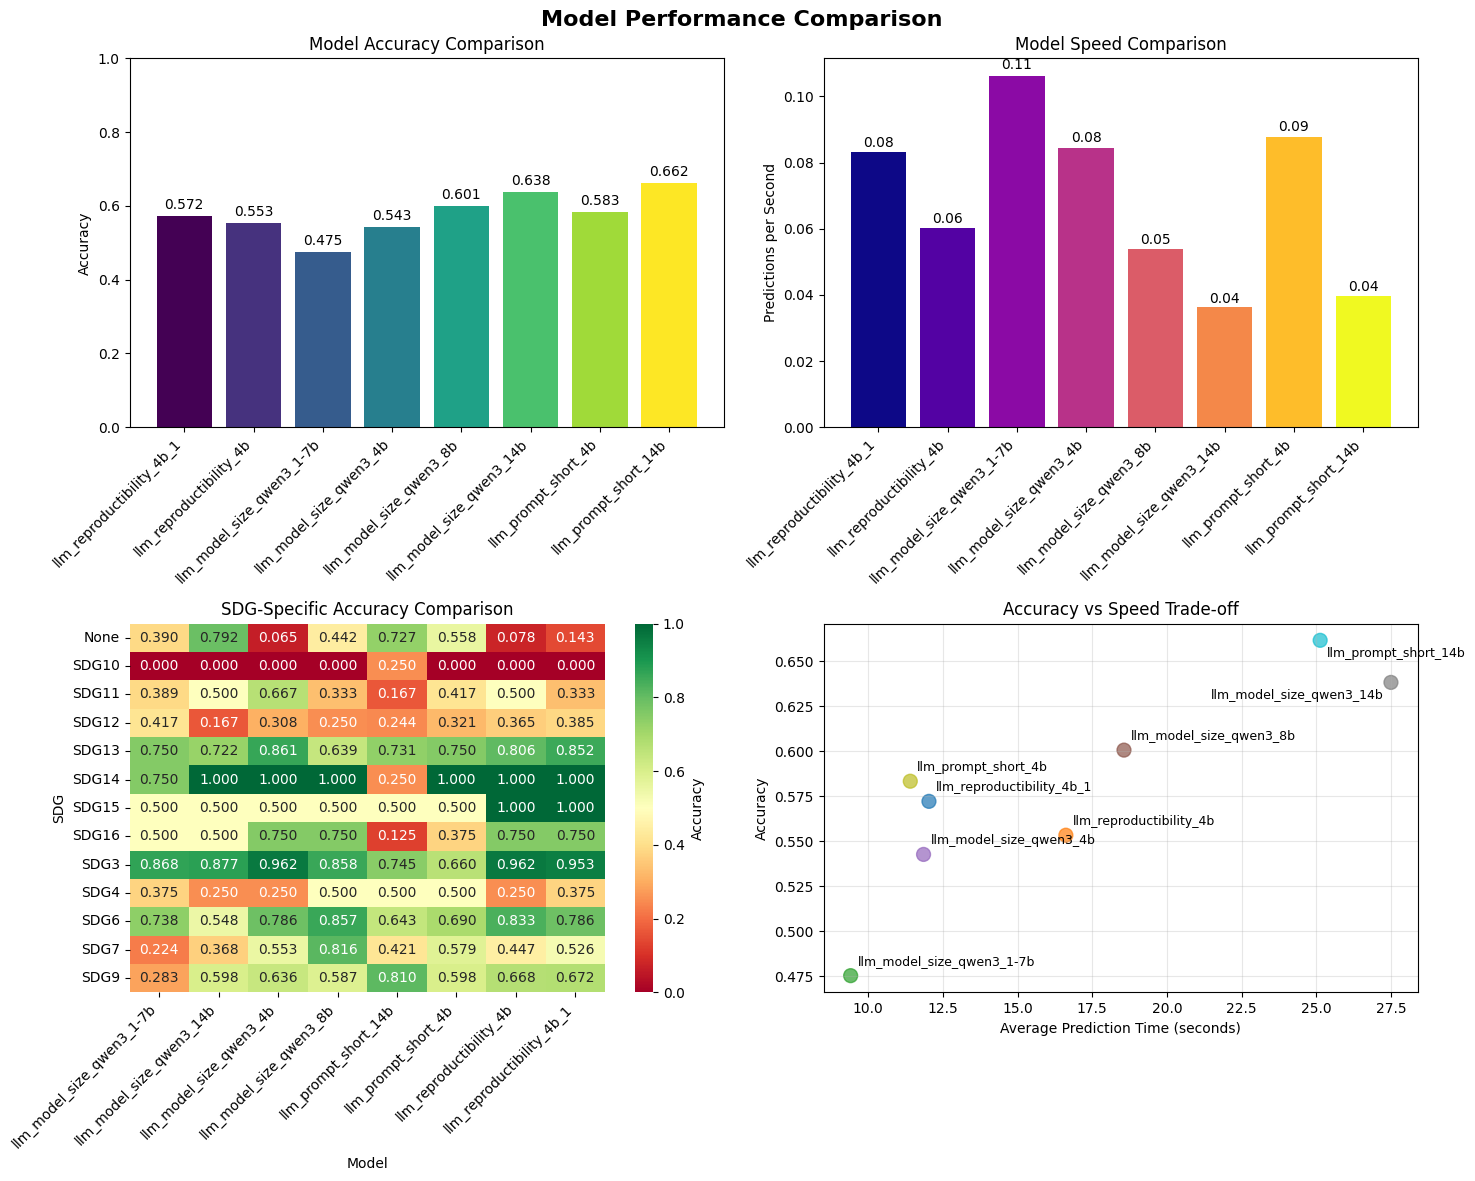


=== DETAILED SDG BREAKDOWN ===
      Accuracy                         Count
          mean     std     min     max   sum
SDG                                         
None    0.3994  0.2854  0.0649  0.7922   616
SDG10   0.0312  0.0884  0.0000  0.2500    16
SDG11   0.4132  0.1481  0.1667  0.6667    48
SDG12   0.3069  0.0833  0.1667  0.4167   208
SDG13   0.7639  0.0734  0.6389  0.8611   144
SDG14   0.8750  0.2673  0.2500  1.0000    32
SDG15   0.6250  0.2315  0.5000  1.0000    16
SDG16   0.5625  0.2315  0.1250  0.7500    32
SDG3    0.8608  0.1088  0.6604  0.9623   424
SDG4    0.3750  0.1157  0.2500  0.5000    32
SDG6    0.7351  0.1037  0.5476  0.8571   168
SDG7    0.4918  0.1738  0.2237  0.8158   152
SDG9    0.6064  0.1492  0.2826  0.8098   736

Best performing SDGs:
  SDG14: 0.875
  SDG3: 0.861
  SDG13: 0.764

Worst performing SDGs:
  SDG4: 0.375
  SDG12: 0.307
  SDG10: 0.031

=== MODEL RANKING ===
Overall Ranking (accuracy + speed):
3. llm_prompt_short_4b (Accuracy: 0.583, Speed: 0.09)


In [21]:
# Exemple d'utilisation:
results = compare_models_evaluation([
    "llm_reproductibility_4b_1.jsonl",
    "llm_reproductibility_4b.jsonl",
    "llm_model_size_qwen3_1-7b.jsonl",
    "llm_model_size_qwen3_4b.jsonl", 
    "llm_model_size_qwen3_8b.jsonl",
    "llm_model_size_qwen3_14b.jsonl",
    "llm_prompt_short_4b.jsonl",
    "llm_prompt_short_14b.jsonl"
    
], extract_all_sdgs_func=extract_all_sdgs)